In [2]:
import jax.numpy as jnp
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import jax
from functools import partial

In [3]:
atomic_model = jnp.load("atomic_model.npy")

In [4]:
@partial(jax.jit, static_argnames=["n_pixels", "pixel_size"])
def gen_img(coord, n_pixels, pixel_size, sigma, ctf):
    
    n_atoms = coord.shape[1]
    norm = 1 / (2 * jnp.pi * sigma**2 * n_atoms)

    grid_min = -pixel_size * (n_pixels - 1)*0.5
    grid_max = pixel_size * (n_pixels - 1)*0.5 + pixel_size

    grid = jnp.arange(grid_min, grid_max, pixel_size)

    gauss = jnp.exp( -0.5 * ( ((grid[:,None] - coord[0,:]) / sigma)**2) )[:,None] * jnp.exp( -0.5 * ( ((grid[:,None] - coord[1,:]) / sigma)**2) )

    image = gauss.sum(axis=2) * norm
    ft_image = jnp.fft.fft2(image, norm="ortho")

    image_ctf = jnp.real(jnp.fft.ifft2(ctf * ft_image, norm="ortho"))
        
    return image_ctf

In [5]:
def gen_quat(num_quaternions):
    #Sonya's code
    
    np.random.seed(0)
    quaternions = np.zeros((num_quaternions, 4))
    count = 0

    while count < num_quaternions:

        quat = np.random.uniform(-1, 1, 4) #note this is a half-open interval, so 1 is not included but -1 is
        norm = np.sqrt(np.sum(quat**2))

        if ( 0.2 <= norm <= 1.0 ):
            quaternions[count] = quat/norm
            count += 1

    return quaternions

@partial(jax.jit, static_argnames=["n_pixels"])
def calc_ctf(n_pixels, pixel_size, amp, phase, b_factor):

    freq_pix_1d = jnp.fft.fftfreq(n_pixels, d=pixel_size)
    freq_x, freq_y = jnp.meshgrid(freq_pix_1d, freq_pix_1d)

    freq2_2d = freq_x**2 + freq_y**2

    env = jnp.exp(-b_factor * freq2_2d * 0.5)

    ctf = amp * jnp.cos(phase * freq2_2d * 0.5) -\
          jnp.sqrt(1 - amp**2) * jnp.sin(phase * freq2_2d * 0.5) + jnp.zeros_like(freq2_2d) * 1j
    
    return ctf * env #/ amp

def add_noise(img, snr):

    np.random.seed(0)

    std_image = np.std(img)

    mask = np.abs(img) > 0.5 * std_image

    signal_mean = np.mean(img[mask])
    signal_std = np.std(img[mask])

    noise_std = signal_std / np.sqrt(snr)
    noise = np.random.normal(loc=signal_mean, scale=noise_std, size=img.shape)

    img_noise = img + noise

    img_noise -= np.mean(img_noise)
    img_noise /= np.std(img_noise)
    
    return img_noise

def create_images(coord, num_images, img_args):

    for key in ["n_pixels", "pixel_size", "sigma", "snr"]:
        assert key in img_args.keys(), f"img_args must contain {key}"

    quats = gen_quat(num_images)
    rot_matrxs = jnp.array(Rotation.from_quat(quats).as_matrix())

    dataset = np.zeros((num_images, img_args["n_pixels"], img_args["n_pixels"]))
    ctfs = np.zeros((num_images, img_args["n_pixels"], img_args["n_pixels"]), dtype=np.complex64)

    b_factor = np.random.rand(num_images)
    defocus = np.random.rand(num_images) * (3.0 - 0.9) + 0.9
    amp = np.random.rand(num_images)

    elecwavel = 0.019866
    phase  = defocus * np.pi * 2. * 10000 * elecwavel 

    for i in range(num_images):

        rot_coord = jnp.array(np.matmul(rot_matrxs[i], coord))

        ctfs[i] = calc_ctf(img_args["n_pixels"], img_args["pixel_size"], amp[i], phase[i], b_factor[i])

        image = gen_img(rot_coord, img_args["n_pixels"], img_args["pixel_size"], img_args["sigma"], ctfs[i])
        image_noise = jnp.array(add_noise(np.array(image), img_args["snr"]))
     
        dataset[i] = image_noise

    return rot_matrxs, jnp.array(ctfs), jnp.array(dataset)

In [6]:
img_args = {"n_pixels": 128,
    "pixel_size": 1,   
    "sigma": 1,
    "snr": 0.1
    }

n_images = 10

In [7]:
%timeit create_images(atomic_model, n_images, img_args)

515 ms ± 31.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
n_images = 10
exp_rots, exp_ctfs, exp_images = create_images(atomic_model, n_images, img_args)

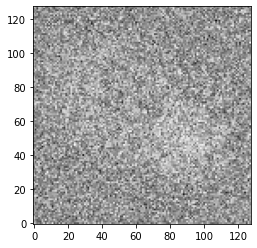

In [9]:
plt.imshow(exp_images[0].T, origin="lower", cmap="Greys_r")

In [10]:
@jax.jit
def calc_loss(image_fwd_model, image_exp):

    loss = jnp.linalg.norm((image_fwd_model - image_exp))**2

    return loss

@jax.jit
def all_images_loss(atomic_coord,
                    exp_images,
                    exp_rots,
                    exp_ctfs#,
                    #img_args
                    ):
    
    for key in ["n_pixels", "pixel_size", "sigma"]:
        assert key in img_args.keys(), f"img_args must contain {key}"

    loss = 0.0
    for i in range(exp_images.shape[0]):

        rot_coord = jnp.matmul(exp_rots[i], atomic_coord)

        image = gen_img(rot_coord, img_args["n_pixels"], img_args["pixel_size"], img_args["sigma"], exp_ctfs[i])
 
        loss += calc_loss(image, exp_images[i])

    return loss

loss_and_grad = jax.jit(jax.value_and_grad(all_images_loss))
        

In [11]:
loss, loss_grad = loss_and_grad(atomic_model, exp_images, exp_rots, exp_ctfs)